In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

/Users/tobi/Documents/CILProject22/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [2]:
class MoTDataset(Dataset):
    def __init__(self, edge_index, rating):
        self.edge_index = edge_index
        self.rating = rating

    def __len__(self):
        return len(self.edge_index)

    def __getitem__(self, idx):
        return self.edge_index[idx], self.rating[idx]

In [3]:
def load_rating_df(path) -> pd.DataFrame:
    """Load the rating dataframe from the given path."""
    df = pd.read_csv(path)
    rating_df = df.Id.str.split("_", expand=True)
    rating_df.columns = ["user", "movie"]
    rating_df["rating"] = df.Prediction
    return rating_df


def compute_gdata(rating_df: pd.DataFrame):
    """Creates the PyTorch Geometric Data object from the rating information"""
    # Create the user and movie indices
    users = rating_df["user"].apply(lambda x: int(x[1:]) - 1)
    movies = rating_df["movie"].apply(lambda x: int(x[1:]) - 1)
    # create edge_index
    edge_index = np.stack([users, movies], axis=1)
    rating = rating_df.rating.values
    # rating = np.ones_like(rating_df.rating.values)
    return MoTDataset(edge_index, rating)


In [4]:
train_df = load_rating_df("../data/cross_validation/train_split_0.csv")
test_df = load_rating_df("../data/cross_validation/test_split_0.csv")

train_df = load_rating_df("../data/data_train.csv")
# test_df = load_rating_df("../data/cross_validation/test_split_0.csv")

# create training and test data
train_dataset = compute_gdata(train_df)
# test_dataset = compute_gdata(test_df)

# create test data loader
# test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

### Model

In [5]:
# Mixture of Tastes model
class MoT(nn.Module):
    def __init__(self, n_users, n_movies, n_tastes, n_components):
        super(MoT, self).__init__()
        self.n_tastes = n_tastes
        self.n_components = n_components

        self.softmax = nn.Softmax(dim=1)
        self.taste_embeddings = nn.Embedding(n_users, n_tastes*n_components)
        self.attention_embeddings = nn.Embedding(n_users, n_tastes*n_components)
        self.movie_embeddings = nn.Embedding(n_movies, n_components)
        self.movie_bias = nn.Embedding(n_movies, 1)
    
    def forward(self, edge):
        user_id = edge[:, 0]
        movie_id = edge[:, 1]
        A_i = self.attention_embeddings(user_id)
        A_i = A_i.view(-1, self.n_tastes, self.n_components)
        attention = self.softmax(torch.bmm(A_i, self.movie_embeddings(movie_id).unsqueeze(-1)))
        U_i = self.taste_embeddings(user_id)
        U_i = U_i.view(-1, self.n_tastes, self.n_components)
        rec_scores = torch.bmm(U_i, self.movie_embeddings(movie_id).unsqueeze(-1))
        y_hat = torch.sum(rec_scores * attention, dim=1) + self.movie_bias(movie_id)
        return y_hat.squeeze()

In [6]:
def loss(pred, edge_label):
    return rmse(pred, edge_label.float())

def rmse(pred, edge_label):
    return torch.sqrt(torch.mean((pred.float() - edge_label.float()) ** 2))

### Training

In [7]:
model = MoT(n_users=10000, n_movies=1000, n_tastes=4, n_components=32)
opt = Adam(model.parameters(), lr=np.exp(-6), weight_decay=np.exp(-11))
train_loader = DataLoader(train_dataset, batch_size=2**12, shuffle=True, drop_last=True)

In [8]:
model.train()
for epoch in range(50):
    print("Epoch:", epoch)
    # for edge, y in test_loader:
    #     y_hat = model(edge)
    #     test_loss = loss(y_hat, y)
    #     test_rmse = rmse(torch.clip(y_hat, 1, 5), y)

    pbar = tqdm(train_loader)
    for edge, y in pbar:
        opt.zero_grad()
        y_hat = model(edge)
        train_loss = loss(y_hat, y)
        train_rmse = rmse(torch.clip(y_hat, 1, 5), y)
        train_loss.backward()
        opt.step()    
        pbar.set_description(
            f"Train loss: {train_loss.item():.4f}, "
            # f"Test loss: {test_loss.item():.4f}, "
            f"Train RMSE: {train_rmse.item():.4f}, "
            # f"Test RMSE: {test_rmse.item():.4f}"
        )

Epoch: 0


Train loss: 4.7305, Train RMSE: 2.5829, : 100%|██████████| 287/287 [00:20<00:00, 13.74it/s]


Epoch: 1


Train loss: 3.5302, Train RMSE: 2.4364, : 100%|██████████| 287/287 [00:20<00:00, 13.80it/s]


Epoch: 2


Train loss: 2.6349, Train RMSE: 2.1884, : 100%|██████████| 287/287 [00:21<00:00, 13.66it/s]


Epoch: 3


Train loss: 1.9605, Train RMSE: 1.8077, : 100%|██████████| 287/287 [00:20<00:00, 14.25it/s]


Epoch: 4


Train loss: 1.4619, Train RMSE: 1.4239, : 100%|██████████| 287/287 [00:20<00:00, 14.32it/s]


Epoch: 5


Train loss: 1.1894, Train RMSE: 1.1802, : 100%|██████████| 287/287 [00:19<00:00, 14.49it/s]


Epoch: 6


Train loss: 1.0588, Train RMSE: 1.0518, : 100%|██████████| 287/287 [00:20<00:00, 14.14it/s]


Epoch: 7


Train loss: 0.9989, Train RMSE: 0.9961, : 100%|██████████| 287/287 [00:19<00:00, 14.42it/s]


Epoch: 8


Train loss: 0.9982, Train RMSE: 0.9970, : 100%|██████████| 287/287 [00:20<00:00, 14.13it/s]


Epoch: 9


Train loss: 0.9573, Train RMSE: 0.9566, : 100%|██████████| 287/287 [00:19<00:00, 14.56it/s]


Epoch: 10


Train loss: 0.9725, Train RMSE: 0.9720, : 100%|██████████| 287/287 [00:19<00:00, 14.59it/s]


Epoch: 11


Train loss: 0.9708, Train RMSE: 0.9706, : 100%|██████████| 287/287 [00:20<00:00, 13.94it/s]


Epoch: 12


Train loss: 0.9825, Train RMSE: 0.9823, : 100%|██████████| 287/287 [00:20<00:00, 13.69it/s]


Epoch: 13


Train loss: 0.9565, Train RMSE: 0.9563, : 100%|██████████| 287/287 [00:21<00:00, 13.56it/s]


Epoch: 14


Train loss: 0.9571, Train RMSE: 0.9569, : 100%|██████████| 287/287 [00:20<00:00, 14.04it/s]


Epoch: 15


Train loss: 0.9790, Train RMSE: 0.9789, : 100%|██████████| 287/287 [00:20<00:00, 14.26it/s]


Epoch: 16


Train loss: 0.9649, Train RMSE: 0.9648, : 100%|██████████| 287/287 [00:21<00:00, 13.47it/s]


Epoch: 17


Train loss: 0.9755, Train RMSE: 0.9755, : 100%|██████████| 287/287 [00:21<00:00, 13.58it/s]


Epoch: 18


Train loss: 0.9639, Train RMSE: 0.9638, : 100%|██████████| 287/287 [00:20<00:00, 13.68it/s]


Epoch: 19


Train loss: 0.9574, Train RMSE: 0.9573, : 100%|██████████| 287/287 [00:20<00:00, 13.79it/s]


Epoch: 20


Train loss: 0.9630, Train RMSE: 0.9629, : 100%|██████████| 287/287 [00:20<00:00, 14.00it/s]


Epoch: 21


Train loss: 0.9677, Train RMSE: 0.9676, : 100%|██████████| 287/287 [00:25<00:00, 11.41it/s]


Epoch: 22


Train loss: 0.9728, Train RMSE: 0.9728, : 100%|██████████| 287/287 [00:20<00:00, 14.08it/s]


Epoch: 23


Train loss: 0.9717, Train RMSE: 0.9716, : 100%|██████████| 287/287 [00:20<00:00, 14.24it/s]


Epoch: 24


Train loss: 0.9541, Train RMSE: 0.9540, : 100%|██████████| 287/287 [00:21<00:00, 13.36it/s]


Epoch: 25


Train loss: 0.9578, Train RMSE: 0.9577, : 100%|██████████| 287/287 [00:21<00:00, 13.39it/s]


Epoch: 26


Train loss: 0.9589, Train RMSE: 0.9589, : 100%|██████████| 287/287 [00:20<00:00, 13.78it/s]


Epoch: 27


Train loss: 0.9473, Train RMSE: 0.9473, : 100%|██████████| 287/287 [00:20<00:00, 13.71it/s]


Epoch: 28


Train loss: 0.9633, Train RMSE: 0.9633, : 100%|██████████| 287/287 [00:22<00:00, 12.90it/s]


Epoch: 29


Train loss: 0.9742, Train RMSE: 0.9742, : 100%|██████████| 287/287 [00:25<00:00, 11.13it/s]


Epoch: 30


Train loss: 0.9629, Train RMSE: 0.9628, : 100%|██████████| 287/287 [00:21<00:00, 13.42it/s]


Epoch: 31


Train loss: 0.9674, Train RMSE: 0.9674, : 100%|██████████| 287/287 [00:22<00:00, 12.97it/s]


Epoch: 32


Train loss: 0.9441, Train RMSE: 0.9441, : 100%|██████████| 287/287 [00:21<00:00, 13.42it/s]


Epoch: 33


Train loss: 0.9549, Train RMSE: 0.9549, : 100%|██████████| 287/287 [00:20<00:00, 13.94it/s]


Epoch: 34


Train loss: 0.9535, Train RMSE: 0.9535, : 100%|██████████| 287/287 [00:19<00:00, 14.71it/s]


Epoch: 35


Train loss: 0.9578, Train RMSE: 0.9578, : 100%|██████████| 287/287 [00:21<00:00, 13.59it/s]


Epoch: 36


Train loss: 0.9484, Train RMSE: 0.9482, : 100%|██████████| 287/287 [00:22<00:00, 13.04it/s]


Epoch: 37


Train loss: 0.9502, Train RMSE: 0.9501, : 100%|██████████| 287/287 [00:21<00:00, 13.62it/s]


Epoch: 38


Train loss: 0.9511, Train RMSE: 0.9510, : 100%|██████████| 287/287 [00:23<00:00, 12.09it/s]


Epoch: 39


Train loss: 0.9514, Train RMSE: 0.9514, : 100%|██████████| 287/287 [00:20<00:00, 14.03it/s]


Epoch: 40


Train loss: 0.9344, Train RMSE: 0.9344, : 100%|██████████| 287/287 [00:20<00:00, 14.21it/s]


Epoch: 41


Train loss: 0.9740, Train RMSE: 0.9739, : 100%|██████████| 287/287 [00:22<00:00, 13.04it/s]


Epoch: 42


Train loss: 0.9692, Train RMSE: 0.9692, : 100%|██████████| 287/287 [00:20<00:00, 13.98it/s]


Epoch: 43


Train loss: 0.9531, Train RMSE: 0.9529, : 100%|██████████| 287/287 [00:21<00:00, 13.17it/s]


Epoch: 44


Train loss: 0.9326, Train RMSE: 0.9325, : 100%|██████████| 287/287 [00:20<00:00, 14.01it/s]


Epoch: 45


Train loss: 0.9720, Train RMSE: 0.9719, : 100%|██████████| 287/287 [00:21<00:00, 13.61it/s]


Epoch: 46


Train loss: 0.9297, Train RMSE: 0.9296, : 100%|██████████| 287/287 [00:20<00:00, 14.15it/s]


Epoch: 47


Train loss: 0.9388, Train RMSE: 0.9387, : 100%|██████████| 287/287 [00:23<00:00, 12.07it/s]


Epoch: 48


Train loss: 0.9628, Train RMSE: 0.9627, : 100%|██████████| 287/287 [00:21<00:00, 13.15it/s]


Epoch: 49


Train loss: 0.9423, Train RMSE: 0.9422, : 100%|██████████| 287/287 [00:20<00:00, 14.15it/s]


In [9]:
sub_df = load_rating_df("../data/sampleSubmission.csv")
sub_dataset = compute_gdata(sub_df)

In [10]:
sub_y_hat = torch.clip(model(torch.tensor(sub_dataset.edge_index)), 1, 5).detach()

<AxesSubplot:ylabel='Count'>

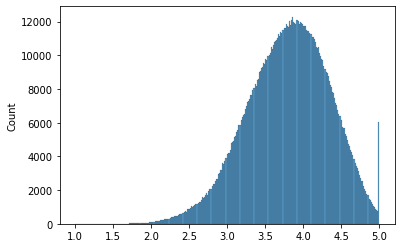

In [11]:
sns.histplot(sub_y_hat)

In [12]:
submission = pd.read_csv("../data/sampleSubmission.csv")
submission["Prediction"] = sub_y_hat.numpy()
submission.to_csv("../data/submission_mot.csv", index=False)